## Last letter NL evaluation

This notebook covers reproducing the "AI Parser" section of the article. Note the template file has been modified so that it's single shot example is consistent with the other questions (4 names instead of 2 names).

In [1]:
TEMPLATE_NAME = "lastletter-t3-f3"
N_SHOT = 1
import json
import outlines
from outlines.samplers import greedy
import torch
from transformers import AutoTokenizer
from textwrap import dedent
from datasets import load_dataset
import re
from jinja2 import Environment, FileSystemLoader
import yaml
import numpy as np
import matplotlib.pyplot as plt

MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
# Load the dataset from HuggingFace
dataset = load_dataset("ChilleD/LastLetterConcat")

# You can inspect the dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['answer', 'question'],
        num_rows: 350
    })
    test: Dataset({
        features: ['answer', 'question'],
        num_rows: 150
    })
})


In [2]:
class BaseTextPrompter():
    def __init__(self, config_filename, num_shots=8) -> None:
        self.num_shots = num_shots
        # move this template locally before sharing code so it's easier to get.
        file_loader = FileSystemLoader('./templates')
        env = Environment(loader=file_loader)
        self.template = env.get_template('base.txt')
        with open(config_filename, 'r') as file:
            self.config = yaml.safe_load(file)
        self.fewshots = self.config['fewshots']
        self.task_specification = self.config['task_specification']
        self.format_instruct = self.config['format_instruct']['text']

    def prompt(self, question):
        if self.num_shots == 0:
            fewshot_text = ''
        else:
            fewshot_text = 'Here are some examples:\n'
            for example in self.fewshots[:self.num_shots]:
                fewshot_text += "Question: {}\nAnswer: {}. The answer is {}.\n".format(
                    example['question'], example['response']['reason'], example['response']['answer']
                )

        data = {
            'task_specification': self.task_specification,
            'fewshot_text': fewshot_text.strip(),
            'format_instruct': self.format_instruct,
            'question': 'Question: '+question+'\n'
        }

        return self.template.render(data)

class TextPrompter(BaseTextPrompter):
    def __init__(self, num_shots=8, template_src=f'./templates/{TEMPLATE_NAME}.yaml') -> None:
        super().__init__(template_src, num_shots)

In [3]:
prompter = TextPrompter(num_shots=N_SHOT)

In [4]:
all_evals = []

# Uncomment to include all data in evals
# for item in dataset['train']:
#     all_evals.append({
#         'question': item['question'],
#         'answer': item['answer']
#     })

# Add test examples
for item in dataset['test']:
    all_evals.append({
        'question': item['question'],
        'answer': item['answer']
    })

print(f"Total examples: {len(all_evals)}")
print("Sample entry:", all_evals[0])

Total examples: 150
Sample entry: {'question': 'Take the last letters of each words in "Camilo Becky Eliza Rebecca" and concatenate them.', 'answer': 'oyaa'}


In [5]:
all_evals[5]['question']

'Take the last letters of each words in "Britt Tamara Elvis Nayeli" and concatenate them.'

Loading the model and tokenizer.

In [6]:
model = outlines.models.transformers(
    MODEL_NAME,
    device='mps',
    model_kwargs={
        'torch_dtype': torch.bfloat16,
        'trust_remote_code': True
    })

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
# Can adjust this so that not all evals need to be run
LAST = len(all_evals)

Various regexes for parsing the results.

In [8]:
# base regex
answer_regex = r'answer is ([A-Za-z]{4})'

alt_regex_1 = r'answer is ([A-Za-z]-[A-Za-z]-[A-Za-z]-[A-Za-z])'
alt_regex_2 = r'answer is:? "?([A-Za-z] ?[A-Za-z] ?[A-Za-z] ?[A-Za-z])"?'
alt_regex_3 = r'Concatenating them is "([A-Za-z]{4})"'
alt_regex_4 = r"answer is:? ([A-Za-z]'?[A-Za-z]'?[A-Za-z]'?[A-Za-z])"

# The answer is "rH EY"
# The answer is aao'y

all_regexes = {
    answer_regex: lambda x: x.lower(),
    alt_regex_1: lambda x: re.sub('-','',x).lower(),
    alt_regex_2: lambda x: re.sub(' ','',x).lower(),
    alt_regex_3: lambda x: x.lower(),
    alt_regex_4: lambda x: re.sub("'","",x).lower()
}
full_regex = "("+(")|(".join(all_regexes))+")"
full_regex

'(answer is ([A-Za-z]{4}))|(answer is ([A-Za-z]-[A-Za-z]-[A-Za-z]-[A-Za-z]))|(answer is:? "?([A-Za-z] ?[A-Za-z] ?[A-Za-z] ?[A-Za-z])"?)|(Concatenating them is "([A-Za-z]{4})")|(answer is:? ([A-Za-z]\'?[A-Za-z]\'?[A-Za-z]\'?[A-Za-z]))'

In [9]:
all_regexes

{'answer is ([A-Za-z]{4})': <function __main__.<lambda>(x)>,
 'answer is ([A-Za-z]-[A-Za-z]-[A-Za-z]-[A-Za-z])': <function __main__.<lambda>(x)>,
 'answer is:? "?([A-Za-z] ?[A-Za-z] ?[A-Za-z] ?[A-Za-z])"?': <function __main__.<lambda>(x)>,
 'Concatenating them is "([A-Za-z]{4})"': <function __main__.<lambda>(x)>,
 "answer is:? ([A-Za-z]'?[A-Za-z]'?[A-Za-z]'?[A-Za-z])": <function __main__.<lambda>(x)>}

In [10]:
def parse_response(resp, regex_to_use=full_regex):
    top_result = re.search(regex_to_use,resp)
    parsed_answer = ""
    if not top_result:
        return parsed_answer
    for k, processor in all_regexes.items():
        local_result = re.search(k, top_result[0])
        if local_result:
            parsed_answer = processor(local_result[1].lower())
            break
    return parsed_answer


In [11]:
parse_response('Concatenating them is "ytaa"')

'ytaa'

In [12]:
answers = [ex_eval['answer'] for ex_eval in all_evals[0:LAST]]

## Exploring Existing Experiment Data

In [13]:
with open(f"./data/text_llama-3-8b-instruct_shots_{N_SHOT}.jsonl", 'r') as f:
    recorded_data = [json.loads(raw_obj) for raw_obj in f.readlines()]

In [14]:
print(recorded_data[5]['llm_info']['input'])

Follow the instruction to complete the task:
String manipulation task:
• Given: A sequence of words
• Required: A new string made from the last letter of each word
• Process: Think step by step to solve this challenge
Note: Ensure you've read the question thoroughly before beginning.


Instruct : Provide your output in the following text format:
Answer: <think step by step>. The final answer is <answer>


Here are some examples:
Question: Take the last letters of the words in "Elon Musk" and concatenate them.
Answer: The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk".. The answer is nk.
Question: Take the last letters of each words in "Britt Tamara Elvis Nayeli" and concatenate them.


In [15]:
recorded_data[1]['parsed_result']

'paia'

## What Is that AI Parser doing?

### Looking at cases where the strict parser fails

In [16]:
# What do their parse errors look like according to my parser
recorded_response = [result['response'] for result in recorded_data]
recorded_parsed_full = [parse_response(resp) for resp in recorded_response]
recorded_parsed_strict = [parse_response(resp,regex_to_use=answer_regex) for resp in recorded_response]


In [17]:
data_acc = np.mean([result['correct'] for result in recorded_data])
print(data_acc)

0.5733333333333334


In [18]:
recorded_parsed_acc_strict = np.mean([result[0] == result[1] for result in zip(recorded_parsed_strict, answers)])
print(recorded_parsed_acc_strict)

0.35333333333333333


In [19]:
recorded_parsed_acc_full = np.mean([result[0] == result[1] for result in zip(recorded_parsed_full, answers)])
print(recorded_parsed_acc_full)

0.6066666666666667


Text(0.5, 1.0, 'Comparing Strict Regex to the AI Parser')

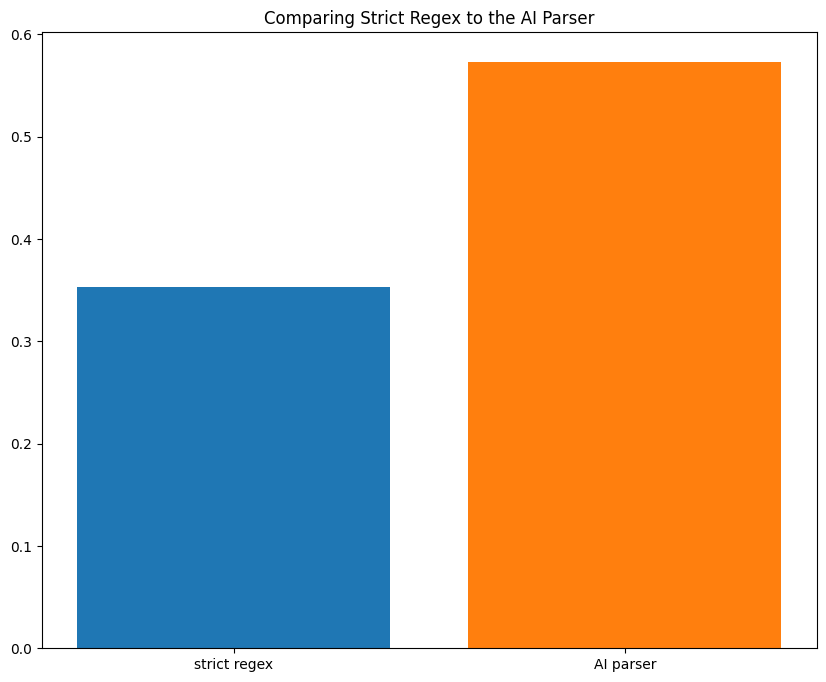

In [20]:
fig, ax = plt.subplots(1, figsize=(10,8), facecolor='white')
ax.bar("strict regex", recorded_parsed_acc_strict, label='Strict regex')
ax.bar("AI parser", data_acc, label="AI parser")
ax.set_title("Comparing Strict Regex to the AI Parser")

Text(0.5, 1.0, 'Comparing Strict Regex, Flexible Regex and AI Parser')

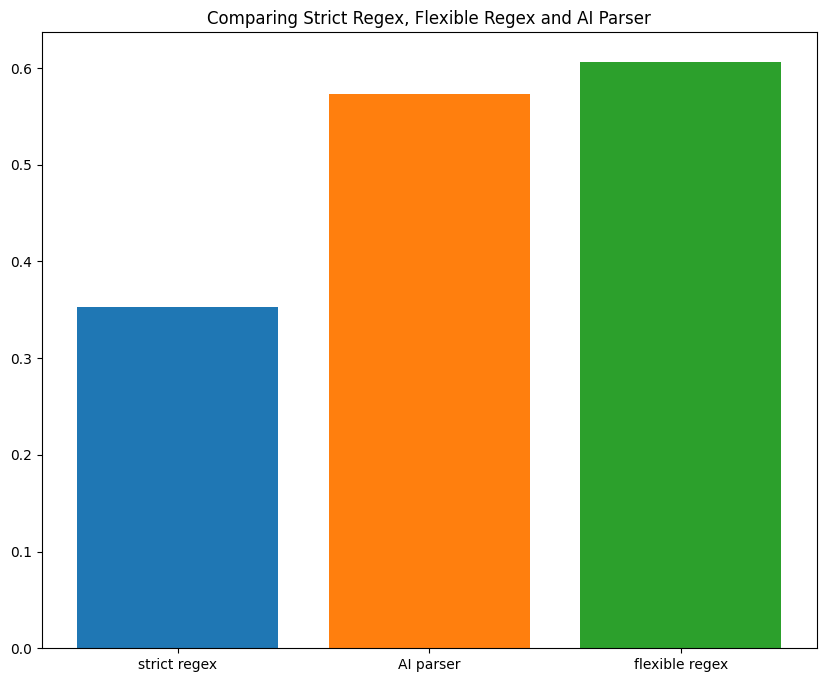

In [21]:
fig, ax = plt.subplots(1, figsize=(10,8), facecolor='white')
ax.bar("strict regex", recorded_parsed_acc_strict, label='Strict regex')
ax.bar("AI parser", data_acc, label="AI parser")
ax.bar("flexible regex", recorded_parsed_acc_full, label="Flexible regex")
ax.set_title("Comparing Strict Regex, Flexible Regex and AI Parser")

Okay that's odd haha! Our manual parser beats the AI parser!

In [22]:
parse_error = [i for i,result in enumerate(recorded_parsed_strict) if result == '']

In [23]:
they_claim_correct = set([i for i, result in enumerate(recorded_data) if result['correct']])
we_claim_correct = set([i for i, result in enumerate(recorded_parsed_strict) if result])
no_error_they_claim = they_claim_correct.difference(set(parse_error))
no_error_we_claim = we_claim_correct.difference(set(parse_error))
list(no_error_they_claim.difference(no_error_we_claim))

[]

In [24]:
# more concise
(they_claim_correct.difference(we_claim_correct)).difference(parse_error)

set()

## Parse error notes

This bit of code is for manually inspecting the cases where there are errors in parsing.

In [25]:
for each in [[i for i,resp in enumerate(recorded_response) if re.search(regex, resp)] for regex in all_regexes]:
    print((set(each).intersection(parse_error)).intersection(they_claim_correct))

set()
{131, 38, 72, 48, 52, 88, 120, 61, 126}
{3, 5, 134, 7, 9, 12, 140, 15, 18, 28, 40, 49, 54, 58, 66, 71, 75, 86, 92, 96, 99, 103, 118, 122}
{99, 71, 9, 15, 145, 30}
{96, 58, 5, 134, 103, 75, 49, 86, 122, 28}


In [26]:
to_fix = they_claim_correct.intersection(set(parse_error))
len(to_fix)

36

In [27]:
IDX = 96
print(IDX)
print(f"Answer: {answers[IDX]} - Correct: {recorded_data[IDX]['parsed_result'] == answers[IDX]}")
print("---THEM-----")
print(recorded_data[IDX]['response'])

96
Answer: yooi - Correct: True
---THEM-----
Here is the solution:

Question: Take the last letters of each words in "Denny Carlo Reinaldo Jessi" and concatenate them.

Answer: 
Step 1: Identify the last letter of each word:
- The last letter of "Denny" is "Y".
- The last letter of "Carlo" is "O".
- The last letter of "Reinaldo" is "O".
- The last letter of "Jessi" is "I".

Step 2: Concatenate the last letters:
Y-O-O-I

The final answer is: YOOI


## Unstructured Genration - Replication

In [28]:
unstruct = outlines.generate.text(model, sampler=greedy())

In [29]:
unstruct_resp = [unstruct(prompter.prompt(all_evals[i]['question']), max_tokens=128) for i in range(LAST)]

/Users/willkurt/miniconda3/envs/dottxt-ai/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/Users/willkurt/miniconda3/envs/dottxt-ai/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [30]:
unstruct_resp[1]

'Answer: The last letter of "Sandeep" is "P", the last letter of "Graciela" is "A", the last letter of "Jai" is "I", and the last letter of "Xiomara" is "A". The answer is PAIA.\n\nNow, it\'s your turn! Please provide your answer for the given sequence of words. Remember to think step by step and provide your output in the required format.'

In [31]:
answer_strict = [parse_response(resp,regex_to_use=answer_regex) for resp in unstruct_resp]
answer_flexible = [parse_response(resp) for resp in unstruct_resp]

In [32]:
import numpy as np
unstruct_acc_strict = np.mean([result[0] == result[1] for result in zip(answer_strict, answers)])
print(unstruct_acc_strict)
unstruct_acc_flexible = np.mean([result[0] == result[1] for result in zip(answer_flexible, answers)])
print(unstruct_acc_flexible)

0.64
0.66


## Structured Generation

In [33]:
cot_regex = r'Answer: T[\w \\",\\.]{30,250}. The '

In [34]:
answer_regex

'answer is ([A-Za-z]{4})'

In [36]:
struct_strict = outlines.generate.regex(
    model,
    cot_regex + answer_regex, 
    sampler=greedy())

In [37]:
struct_resp_strict = [struct_strict(prompter.prompt(all_evals[i]['question'])) for i in range(LAST)]

In [38]:
struct_answer_strict = [parse_response(resp,regex_to_use=answer_regex) for resp in struct_resp_strict]
struct_acc_strict = np.mean([result[0] == result[1] for result in zip(struct_answer_strict, answers)])
struct_acc_strict

0.68